# SRResnet-GAN

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, PReLU, LeakyReLU, Layer, Conv2D, BatchNormalization, Flatten
from tensorflow.keras.applications.vgg16 import VGG16

## Residual Block

In [ ]:
class ResidualBlock(Layer):
    def __init__(self, channel=64, kernel_size=(3, 3)):
        super().__init__()
        self.conv1 = Conv2D(channel, kernel_size, padding='same', use_bias=False)
        self.bn1 = BatchNormalization()
        self.prelu = PReLU()
        self.conv2 = Conv2D(channel, kernel_size, padding='same', use_bias=False)
        self.bn2 = BatchNormalization()

    def call(self, x, training=None, mask=None):
        h = self.prelu(self.bn1(self.conv1(x), training))
        return x + self.bn2(self.conv2(h), training)

## Conv-Bn-Relu Block

In [ ]:
class ConvBnLReluBlock(Layer):
    def __init__(self, channel=64, kernel_size=(3, 3)):
        super().__init__()
        self.conv = Conv2D(channel, kernel_size, padding='same', use_bias=False)
        self.bn = BatchNormalization()
        self.lrelu = LeakyReLU()

    def call(self, x, training=None, mask=None):
        return self.lrelu(self.bn(self.conv(x), training))

## Generator (SRResnet)

In [ ]:
class Generator(Model):
    def __init__(self, channel=64, num_resblock=5):
        super().__init__()
        self.conv1 = Conv2D(channel, (9, 9), padding='same')
        self.prelu1 = PReLU()
        
        self.resblock_list = [ResidualBlock(channel, (3, 3)) for _ in range(num_resblock)]
        
        self.conv2 = Conv2D(channel, (3, 3), padding='same', use_bias=False)
        self.bn = BatchNormalization()
        self.prelu2 = PReLU()
        
        self.conv3 = Conv2D(channel * 4, (3, 3), padding='same')
        self.prelu3 = PReLU()
        
        self.conv4 = Conv2D(channel * 4, (3, 3), padding='same')
        self.prelu4 = PReLU()
        self.conv5 = Conv2D(3, (9, 9), padding='same')

    def call(self, x, training=None, mask=None):
        h = self.prelu1(self.conv1(x))
        h_skip = h
        
        for resblock in self.resblock_list:
            h = resblock(h, training)
        
        h = self.prelu2(self.bn(self.conv2(h), training))
        h = h + h_skip
        
        h = self.prelu3(tf.nn.depth_to_space(self.conv3(h), 2))
        h = self.prelu4(tf.nn.depth_to_space(self.conv4(h), 2))
        return self.conv5(h)

## Discriminator

In [ ]:
class Discriminator(Model):
    def __init__(self, channel=64):
        super().__init__()
        self.conv1 = Conv2D(channel, (3, 3), padding='same')
        self.lrelu1 = LeakyReLU()
        
        self.block_list = list()
        self.block_list.append(ConvBnLReluBlock(channel))
        self.block_list.append(ConvBnLReluBlock(channel * 2))
        self.block_list.append(ConvBnLReluBlock(channel * 2))
        self.block_list.append(ConvBnLReluBlock(channel * 4))
        self.block_list.append(ConvBnLReluBlock(channel * 4))
        self.block_list.append(ConvBnLReluBlock(channel * 8))
        self.block_list.append(ConvBnLReluBlock(channel * 8))
        
        self.flatten = Flatten()
        self.dense1 = Dense(1024)
        self.lrelu2 = LeakyReLU()
        self.dense2 = Dense(1, activation='sigmoid')

    def call(self, x, training=None, mask=None):
        h = self.lrelu1(self.conv1(x))
        for block in self.block_list:
            h = block(h, training)
        h = self.flatten(h)
        h = self.lrelu2(self.dense1(h))
        return self.dense2(h)

## Dataset (Caltech101)

In [ ]:
dataset = tfds.load(name='cifar10', split='train[:10%]')
dataset = dataset.map(lambda x: (tf.image.resize(tf.cast(x['image'], tf.float32), (8, 8), tf.image.ResizeMethod.BICUBIC) / 255.0,
                                 tf.image.resize(tf.cast(x['image'], tf.float32), (32, 32), tf.image.ResizeMethod.BICUBIC) / 255.0)).batch(1)

## VGG Model, Hyperparameters

In [ ]:
generator = Generator(16)
discriminator = Discriminator(16)

vgg = VGG16(include_top=False, weights='imagenet', input_shape=(32,32, 3))
vgg = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
vgg.trainable = False

w_gan = 1e-2
w_vgg = 1e-5

optim_d = tf.optimizers.Adam(1e-4)
optim_g = tf.optimizers.Adam(1e-4)

d_mean = tf.metrics.Mean()
g_mean = tf.metrics.Mean()
vgg_mean = tf.metrics.Mean()
l1_mean = tf.metrics.Mean()

## Losses

In [ ]:
@tf.function
def l1_loss_func(y, y_):
    return tf.reduce_mean(tf.abs(y - y_))

@tf.function
def vgg_loss_func(y, y_):
    return tf.reduce_mean((vgg(y) - vgg(y_)) ** 2)

@tf.function
def discriminator_loss(real, fake):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real), real)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake), fake)
    return real_loss + fake_loss

@tf.function
def generator_loss(fake):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake), fake)


## Training Step

In [ ]:
@tf.function
def train_step(image_lr, image_hr, optim_d, optim_g):
    with tf.GradientTape() as tape_d, tf.GradientTape() as tape_g:
        image_sr = generator(image_lr, training=True)
        
        d_real = discriminator(image_hr, training=True)
        d_fake = discriminator(image_sr, training=True)
        
        d_loss = discriminator_loss(d_real, d_fake)
        g_loss = generator_loss(d_fake)
        
        vgg_loss = vgg_loss_func(image_hr, image_sr)
        l1_loss = l1_loss_func(image_hr, image_sr)
        
        loss = w_gan * g_loss + w_vgg * vgg_loss + l1_loss
        
        gradients_d = tape_d.gradient(d_loss, discriminator.trainable_weights)
        gradients_g = tape_g.gradient(loss, generator.trainable_weights)
    
    optim_d.apply_gradients(zip(gradients_d, discriminator.trainable_weights))
    optim_g.apply_gradients(zip(gradients_g, generator.trainable_weights))
    return d_loss, g_loss, vgg_loss, l1_loss

## Training Loop

epoch: 1, d_loss: 14.886293411254883, g_loss: 0.365660697221756, vgg_loss: 58.45869827270508, l1_loss: 0.13096845149993896


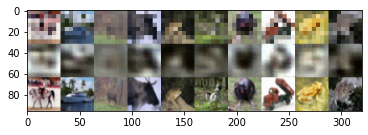

epoch: 2, d_loss: 15.24980354309082, g_loss: 0.0, vgg_loss: 44.116336822509766, l1_loss: 0.091154545545578


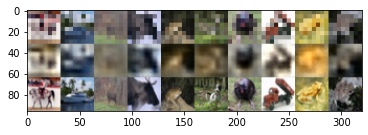

epoch: 3, d_loss: 15.24980354309082, g_loss: 0.0, vgg_loss: 38.58637237548828, l1_loss: 0.0818149521946907


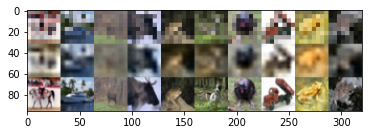

epoch: 4, d_loss: 15.24980354309082, g_loss: 0.0, vgg_loss: 36.24198913574219, l1_loss: 0.07860668003559113


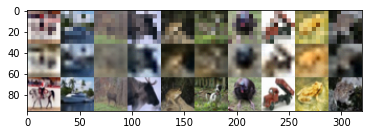

epoch: 5, d_loss: 15.24980354309082, g_loss: 0.0, vgg_loss: 34.917232513427734, l1_loss: 0.0768875852227211


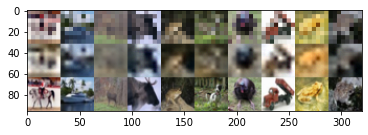

epoch: 6, d_loss: 15.24980354309082, g_loss: 0.0, vgg_loss: 33.9864616394043, l1_loss: 0.07524275034666061


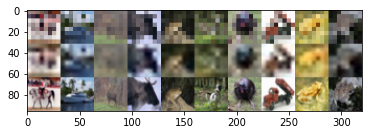

epoch: 7, d_loss: 15.24980354309082, g_loss: 0.0, vgg_loss: 32.98244094848633, l1_loss: 0.07286736369132996


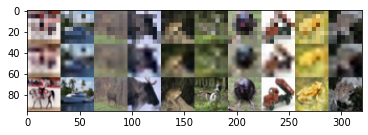

epoch: 8, d_loss: 15.24980354309082, g_loss: 0.0, vgg_loss: 32.021942138671875, l1_loss: 0.07172820717096329


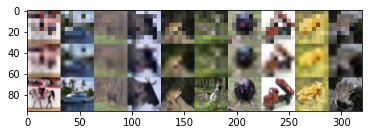

epoch: 9, d_loss: 15.24980354309082, g_loss: 0.0, vgg_loss: 31.308034896850586, l1_loss: 0.07092978805303574


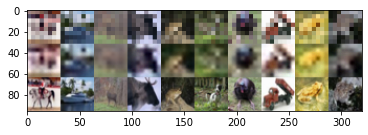

epoch: 10, d_loss: 15.24980354309082, g_loss: 0.0, vgg_loss: 30.8007869720459, l1_loss: 0.07034167647361755


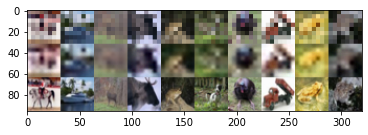

epoch: 11, d_loss: 15.24980354309082, g_loss: 0.0, vgg_loss: 30.42180061340332, l1_loss: 0.06986980885267258


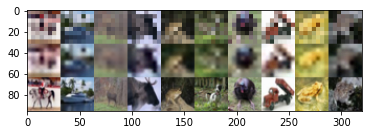

epoch: 12, d_loss: 15.24980354309082, g_loss: 0.0, vgg_loss: 30.131099700927734, l1_loss: 0.06949320435523987


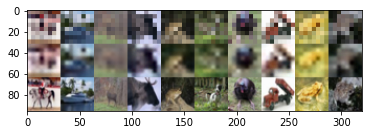

epoch: 13, d_loss: 15.24980354309082, g_loss: 0.0, vgg_loss: 29.893056869506836, l1_loss: 0.06916859745979309


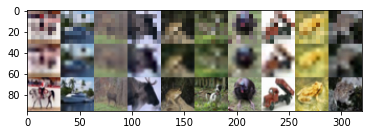

epoch: 14, d_loss: 15.24980354309082, g_loss: 0.0, vgg_loss: 29.69756317138672, l1_loss: 0.06891091167926788


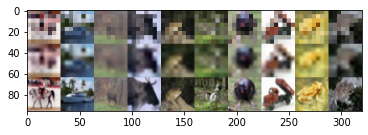

In [ ]:
for epoch in range(100):
    for img_lr, img_hr in dataset:
        d_loss, g_loss, vgg_loss, l1_loss = train_step(img_lr, img_hr, optim_d, optim_g)

        d_mean.update_state(d_loss)
        g_mean.update_state(g_loss)
        vgg_mean.update_state(vgg_loss)
        l1_mean.update_state(l1_loss)

    print('epoch: {}, d_loss: {}, g_loss: {}, vgg_loss: {}, l1_loss: {}'.format(epoch+1,
                                                                d_mean.result(),
                                                                g_mean.result(),
                                                                vgg_mean.result(),
                                                                l1_mean.result()))
    img_sr_list = list()
    img_lr_list = list()
    img_hr_list = list()
    for img_lr, img_hr in dataset.take(10):
        img_sr = generator(img_lr)
        
        img_lr_list.append(tf.image.resize(img_lr[0], (32,32),
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR))
        img_sr_list.append(img_sr[0])
        img_hr_list.append(img_hr[0])
    
    img_lr = np.concatenate(img_lr_list, axis=1)
    img_sr = np.concatenate(img_sr_list, axis=1)
    img_hr = np.concatenate(img_hr_list, axis=1)
    img = np.concatenate([img_lr, img_sr, img_hr], axis=0)
    
    plt.imshow(img)
    plt.show()

    d_mean.reset_states()
    g_mean.reset_states()
    vgg_mean.reset_states()
    l1_mean.reset_states()